In [1]:
# Importing libraries
import warnings
warnings.filterwarnings('ignore')
import sqlite3
import pandas as pd
import numpy as np
from time import time
from nltk.corpus import stopwords
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import gensim

In [2]:
#数据导入
file_path = './Problem_C_Data/microwave.tsv'
df = pd.read_csv(file_path, sep='\t', header=0)
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,21879631,RY52KZABZK8QF,B0052G14E8,423421857,danby 0.7 cu.ft. countertop microwave,Major Appliances,1,0,0,N,Y,Do not recommend it. go use your money for som...,3 of the buttons stopped working after a month...,8/31/2015
1,US,14964566,R3GCOEV4HYZG2I,B0055UBB4O,423421857,danby 0.7 cu.ft. countertop microwave,Major Appliances,5,0,0,N,Y,Looks as good as the picture,Didn't use it long so I can't attest to that b...,8/31/2015
2,US,13230389,R1V2OPPNL0QGCE,B0052G14E8,423421857,danby 0.7 cu.ft. countertop microwave,Major Appliances,4,0,0,N,Y,Four Stars,"Very nice microwave, great price",8/31/2015
3,US,43655888,R9Q0QDTLKV567,B004ZU09QQ,423421857,danby 0.7 cu.ft. countertop microwave,Major Appliances,3,0,1,N,Y,quiet,"Quiet, but does not seem like 1000 watt power.",8/31/2015
4,US,117794,R3DL7HYC3QTWNI,B005GSZB7I,827502283,"whirlpool stainless look countertop microwave,...",Major Appliances,4,0,0,N,Y,Four Stars,It's bigger than I thought.,8/31/2015


In [3]:
#保留不是3的评论
filtered_data = df[df['star_rating'] != 3]
def partition(x):
    if x>3:
        return 'positive'
    return 'negative'

actual_score = filtered_data['star_rating']
positiveNegative = actual_score.map(partition)
filtered_data['Score'] = positiveNegative
filtered_data.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,Score
0,US,21879631,RY52KZABZK8QF,B0052G14E8,423421857,danby 0.7 cu.ft. countertop microwave,Major Appliances,1,0,0,N,Y,Do not recommend it. go use your money for som...,3 of the buttons stopped working after a month...,8/31/2015,negative
1,US,14964566,R3GCOEV4HYZG2I,B0055UBB4O,423421857,danby 0.7 cu.ft. countertop microwave,Major Appliances,5,0,0,N,Y,Looks as good as the picture,Didn't use it long so I can't attest to that b...,8/31/2015,positive
2,US,13230389,R1V2OPPNL0QGCE,B0052G14E8,423421857,danby 0.7 cu.ft. countertop microwave,Major Appliances,4,0,0,N,Y,Four Stars,"Very nice microwave, great price",8/31/2015,positive
4,US,117794,R3DL7HYC3QTWNI,B005GSZB7I,827502283,"whirlpool stainless look countertop microwave,...",Major Appliances,4,0,0,N,Y,Four Stars,It's bigger than I thought.,8/31/2015,positive
5,US,16018452,R3M88678ZYC6WI,B004ZU09QQ,423421857,danby 0.7 cu.ft. countertop microwave,Major Appliances,5,0,0,N,Y,Great Microwave,Really love this microwave. Has the one touch ...,8/31/2015,positive


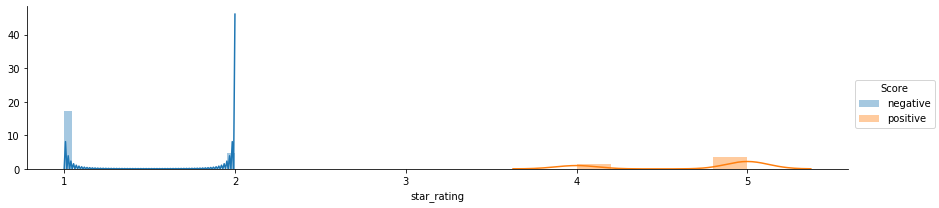

In [4]:
import seaborn as sns

for i in ['star_rating']:
    sns.FacetGrid(data = filtered_data, hue='Score', aspect=4).map(sns.distplot, i).add_legend(); plt.show()

In [5]:
# Sorting data points according to the 'ProductId'
sorted_data = filtered_data.sort_values('product_id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Eliminating the duplicate data points based on: 'UserId', 'ProfileName', 'Time', 'Summary'
final = sorted_data.drop_duplicates(subset={'review_id', 'product_title', 'review_date', 'review_body'}, keep='first', inplace=False)

# Eliminating the row where 'HelpfulnessDenominator' is greater than 'HelpfulnessNumerator' as these are the wrong entry
final = final[final['total_votes'] >= final['helpful_votes']]

# Getting shape of final data frame
display(final.shape)

(1481, 16)

In [6]:
nltk.download("stopwords")

[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     远程主机强迫关闭了一个现有的连接。>


False

In [7]:
%%time

# Creating the set of stopwords
stop = set(stopwords.words('english'))

# For stemming purpose
snow = nltk.stem.SnowballStemmer('english')

# Defining function to clean html tags
def cleanhtml(sentence):
    cleaner = re.compile('<.*>')
    cleantext = re.sub(cleaner, ' ', sentence)
    return cleantext

# Defining function to remove special symbols
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|.|!|*|@|#|\'|"|,|)|(|\|/]', r'', sentence)
    return cleaned


# Important steps to clean the text data. Please trace it out carefully
i = 0
str1 = ''
all_positive_words = []
all_negative_words = []
final_string = []
s=''
for sent in final['review_headline'].values+final['review_body'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if (cleaned_words.lower() not in stop):
                    s = (snow.stem(cleaned_words.lower())).encode('utf-8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_words.append(s)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence)
    final_string.append(str1)
    i += 1
    
# Adding new column into dataframe to store cleaned text
final['CleanedText'] = final_string
final['CleanedText'] = final['CleanedText'].str.decode('utf-8')


# Getting shape of new datset
print(final.shape)

(1481, 17)
Wall time: 1.48 s


In [8]:
final.head(3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,Score,CleanedText
1601,US,12353377,R1X53E4WYB0D8O,B00009V3WS,459626087,sharp 1.1-cubic-foot 850-watt over-the-range c...,Major Appliances,4,6,8,N,N,Over the Range Sharp Convection/Microwave oven,I love it. The only problem is the popcorn bu...,10/9/2005,positive,rang sharp convectionmicrowav oveni love probl...
1563,US,51558013,R2WXEFZ3C0R8WA,B00009V3WS,459626087,sharp 1.1-cubic-foot 850-watt over-the-range c...,Major Appliances,2,10,11,N,N,Beware the Bummer Oven,I had to buy this model microwave because my k...,10/12/2008,negative,bewar bummer oveni buy model microwav kitchen ...
1300,US,51994627,R35CPZSQEQ1QJW,B00009V3WT,459626087,sharp 1.1-cubic-foot 850-watt over-the-range c...,Major Appliances,4,6,6,N,Y,The best available,When our old Sharp &#34;over the range&#34; st...,12/30/2012,positive,best availablewhen old sharp start die year se...


We can see that the new dataset is containing new column with cleaned text which will be useful for next procedure.

In [9]:
# Getting the number of data points in each class: positive or negative
display(final['Score'].value_counts())
total_points = final
# It can be observed that the data set is imbalanced.
# There are much more data points belonging to positive class than negative.

positive    967
negative    514
Name: Score, dtype: int64

### BoW

In [10]:
%%time
# Initializing vectorizer for bigram
count_vect = CountVectorizer(ngram_range=(1,1))

# Initializing standard scaler
std_scaler = StandardScaler(with_mean=False)

# Creating count vectors and converting into dense representation
sample_points = total_points['CleanedText']
sample_points = count_vect.fit_transform(sample_points)
sample_points = std_scaler.fit_transform(sample_points)
sample_points = sample_points.todense()

# Storing class label in variable
labels = total_points['Score']

# Getting shape
print(sample_points.shape, labels.shape)

(1481, 4574) (1481,)
Wall time: 73.8 ms


### TSNE for Word2Vec

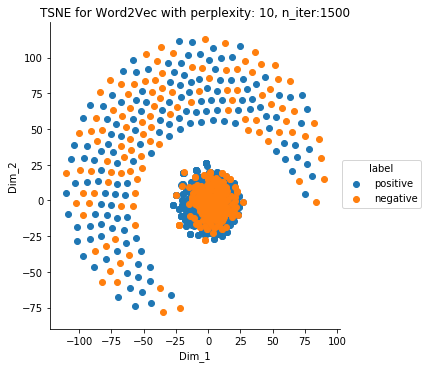

Wall time: 30.6 s


In [21]:
%%time
from sklearn.manifold import TSNE

tsne_data = sample_points
tsne_labels = labels

# Initializing with most explained variance
model = TSNE(n_components=2, random_state=18, perplexity = 13)

# Fitting model
tsne_data = model.fit_transform(tsne_data)

# Adding labels to the data point
tsne_data = np.vstack((tsne_data.T, tsne_labels)).T

# Creating data frame
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))

# Plotting graph for class labels
sb.FacetGrid(tsne_df, hue='label', size=5).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE for Word2Vec with perplexity: 10, n_iter:1500")
plt.xlabel("Dim_1")
plt.ylabel("Dim_2")
plt.show()
# Almost all the negative and positive labels are overlapping to each other which means, even after applying tSNE, class labels are not separated.

## TF-IDF

In [12]:
%%time

# Initializing tf-idf vectorizer for bigram
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))

tfidf_data = total_points['CleanedText']
tfidf_data = tfidf_vect.fit_transform(tfidf_data)
tfidf_data = tfidf_data.todense()

tfidf_labels = labels

Wall time: 204 ms


In [13]:
print(tfidf_data.shape, tfidf_labels.shape)

(1481, 39038) (1481,)


### TSNE for TF-IDF¶


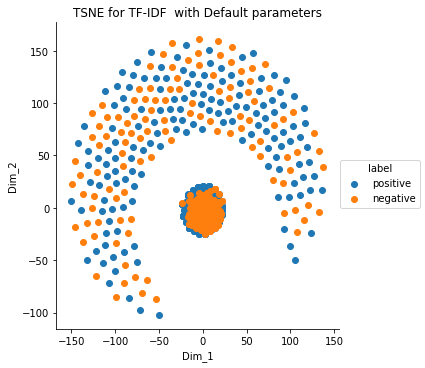

Wall time: 46.1 s


In [15]:
%%time
from sklearn.manifold import TSNE

tsne_data = sample_points
tsne_labels = labels

# Initializing with most explained variance
model = TSNE(n_components=2, random_state=15, perplexity=20, n_iter=2000)

# Fitting model
tsne_data = model.fit_transform(tsne_data)

# Adding labels to the data point
tsne_data = np.vstack((tsne_data.T, tsne_labels)).T

# Creating data frame
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))

# Plotting graph for class labels
sb.FacetGrid(tsne_df, hue='label', size=5).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE for TF-IDF  with Default parameters")
plt.xlabel("Dim_1")
plt.ylabel("Dim_2")
plt.show()

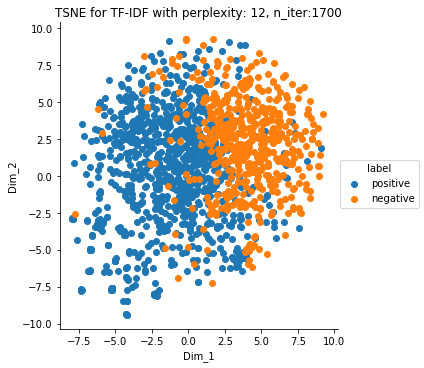

Wall time: 2min 46s


In [17]:
%%time

model = TSNE(n_components=2, random_state=15, perplexity=12, n_iter=1700)

# Fitting model
tsne_data = model.fit_transform(tfidf_data)


# Attaching feature and label
tsne_data = np.vstack((tsne_data.T, tfidf_labels)).T

# Creating data frame
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))

# Plotting graph for class labels
sb.FacetGrid(tsne_df, hue='label', size=5).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE for TF-IDF with perplexity: 12, n_iter:1700")
plt.xlabel("Dim_1")
plt.ylabel("Dim_2")
plt.show()


In [18]:
# Getting text from Review
w2v_points = total_points['review_headline']+total_points['review_body']
w2v_labels = labels.copy()

In [19]:
import re
def cleanhtml(sentence):
    cleantext = re.sub('<.*>', '', sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|#|@|.|,|)|(|\|/]', r'', sentence)
    return cleaned

# Creating list of sentences
sent_list = []
for sent in w2v_points:
    sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                sentence.append(cleaned_words.lower())
            else:
                continue
    sent_list.append(sentence)

In [20]:
# Initializing model for words occur atleast 5 times
w2v_model = gensim.models.Word2Vec(sent_list, min_count=5, size=50, workers=4)

# Applying model for word2vec
w2v_words = w2v_model[w2v_model.wv.vocab]

In [21]:
print(w2v_words.shape)


(1619, 50)


In [22]:
# Getting 10 similar words
display(w2v_model.wv.most_similar("good"))

[('nice', 0.9988126158714294),
 ('very', 0.9983128309249878),
 ('little', 0.9979847073554993),
 ('size', 0.9979224801063538),
 ('looks', 0.9978845119476318),
 ('far', 0.9978002309799194),
 ('perfect', 0.9977363348007202),
 ('price', 0.9976538419723511),
 ('small', 0.9976066946983337),
 ('well', 0.9970976114273071)]

## Avg W2V

In [23]:
# Producing average word to vec vectors
import numpy as np
sent_vectors = []
for sent in sent_list:
    sent_vec = np.zeros(200)
    cnt_words = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.nan_to_num(sent_vectors)
print(sent_vectors.shape)


(1481, 200)


## TSNE for Avg W2V
### Default parameters

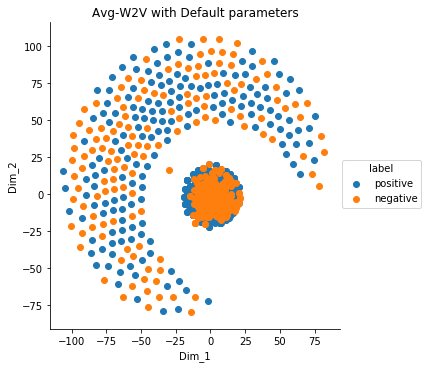

Wall time: 42.5 s


In [24]:
%%time
from sklearn.manifold import TSNE

tsne_data = sample_points
tsne_labels = labels

# Initializing with most explained variance
model = TSNE(n_components=2, random_state=15)

# Fitting model
tsne_data = model.fit_transform(tsne_data)

# Adding labels to the data point
tsne_data = np.vstack((tsne_data.T, tsne_labels)).T

# Creating data frame
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))

# Plotting graph for class labels
sb.FacetGrid(tsne_df, hue='label', size=5).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("Avg-W2V with Default parameters")
plt.xlabel("Dim_1")
plt.ylabel("Dim_2")
plt.show()

## Observation:
* Even though t-SNE is very powerful technique to visualize high dimension data but still it's unable to separate the class labels in our dataset.
* It accepts dense matrix to execute on it but computationally it is very expensive for much higher dimensional data as in our case.
* There were completely overlapping of class labels on each other that means t-SNE failed to separate the class labels.
* Changing parameters and getting stable t-SNE model is very important but even after trying out many combinations of parameters. It is found out that it doesn't help in our case of Amazon Fine Food Reviews dataset and some of the parameter adjustment are shown here also.

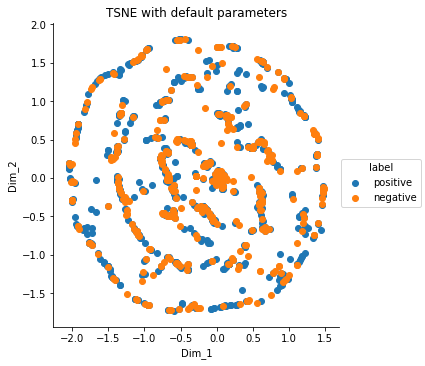

Wall time: 12.7 s


In [25]:
%%time

model = TSNE(n_components=2, random_state=15)

# Fitting model
w2v_points = model.fit_transform(sent_vectors)


# Attaching feature and label
tsne_data = np.vstack((w2v_points.T, w2v_labels)).T

# Creating data frame
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))

# Plotting graph for class labels
sb.FacetGrid(tsne_df, hue='label', size=5).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with default parameters")
plt.xlabel("Dim_1")
plt.ylabel("Dim_2")
plt.show()